In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import histogram


Train Data assesment and Cleaning 
The sounds are periodic. We don't to asses the entire spectogram but a small snippet of it. Our aim is to asses the frequency distribution of that sound and simultaneous tempooral distribution to train our model for various classes of sounds given.

In [4]:


data=pd.read_csv("./annotations.csv")
files=data["fname"]   #read file names in sequential order as in annotations.csv


x=np.zeros((1000,19*128))
flagg=np.zeros((1000,3))  #flag variable to store features of all data points
temp1=np.zeros((19,128))

j=0

for i in files:
    temp=np.load("./train/"+ i)
    frames=temp.shape[2]
    flagg[j,0]=frames     #no.of data frames given in each data-point
    
    #repeat the spectrogram if file width is less than 200 since we will require minimum 200 frames
    if frames<100:
        temp=np.tile(temp,300//frames+1)
        frames=temp.shape[2]
    
    #find max column vect
    sum_ver=np.sum(temp,axis=1)
    t=np.argmax(sum_ver)   
    flagg[j,1]=t
    
    
    # selects a snipet of spectrogram of width 100 as sample
    if flagg[j,1]<100:
        temp=temp[:,:,0:200]
    elif flagg[j,1]>frames-100:
        temp=temp[:,:,-200:]
    else:
        temp=temp[:,:,t-100:t+100]
    
    #convolution of window 1x20 and hop=10. We convolving to find temporal variation of frequencies 
    #and not tamper with frequency distribution itself
    for k in range(0,19):
        temp1[k]=np.sum(temp[:,:,10*k:10*k+20],axis=-1).reshape(1,128)
   

    x[j]=temp1.flatten('F') #training data
    
    flagg[j,2]=np.sum(x[j])  #to find outliers in training data
    j=j+1

print(x.shape)

#Averaging all train sample of shape (1,2432) to values less than 1 for easier calculation of softmax
x_soft=x/(np.sum(x,axis=1).reshape(1000,1)+0.00000000000000000000001)
print(x_soft.shape)


(1000, 2432)
(1000, 2432)


391
696761.151845932


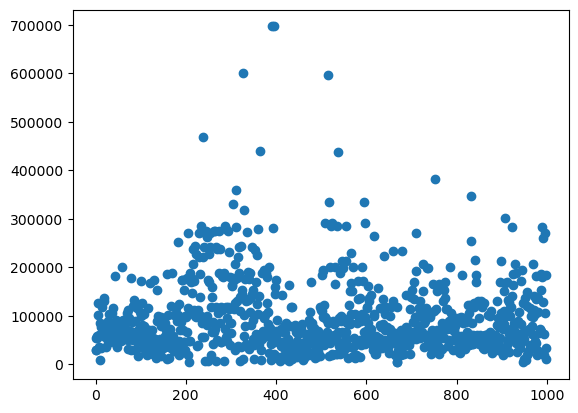

In [6]:
#find any outliers in data that will create a problem in calculating exponentials of softmax

plt.scatter(range(0,1000),flagg[:,2])
print(np.argmax(flagg[:,2]))
print(np.max(flagg[:,2]))


In [3]:
count=np.nonzero(flagg[:,2]>300000)
print(count)

#all data points that exceed total sum of 300000 are scaled down appropriately
for i in count:
    x[i]=x[i]/20
    flagg[i,2]=np.sum(x[i])

plt.scatter(range(0,1000),flagg[:,2])
count=np.nonzero(flagg[:,2]>300000)
print(count)

NameError: name 'flagg' is not defined

[ 1404.           985.         60550.56143141]


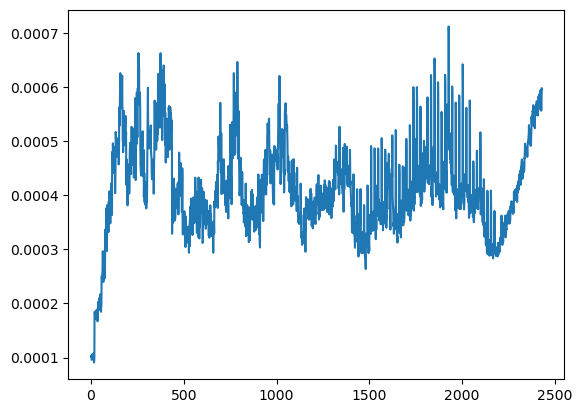

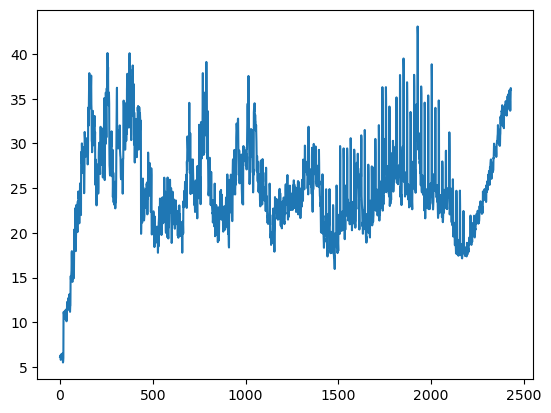

In [10]:
#training sample visusualisation
s=600

print(flagg[s])
plt.plot(range(0,19*128),x_soft[s])
plt.figure(2)
plt.plot(range(0,19*128),x[s])

In [5]:
from sklearn import preprocessing

encode=preprocessing.LabelEncoder()
y1 = encode.fit_transform(data["label"]) #every classifier is encodded with a number
y= (pd.get_dummies(y1).values) #number  is converter to one-hot vector


t2=y1[0:1000:100]

dict_class={}   #dictionary of one hot vector with respective class

for i in range(0,10):
    j=int(np.argwhere(t2==i))
    dict_class[i]=data["label"][100*j]
print(dict_class)




{0: 'Bark', 1: 'Crying_and_sobbing', 2: 'Doorbell', 3: 'Knock', 4: 'Meow', 5: 'Microwave_oven', 6: 'Shatter', 7: 'Siren', 8: 'Vehicle_horn_and_car_horn_and_honking', 9: 'Walk_and_footsteps'}


In [6]:
p=100
q=100-p
x_train=x_soft[0:p]
y_train=y[0:p]

print(x_train.shape)
for i in range(1,10):
    x_train=np.concatenate((x_train,x_soft[i*100:i*100+p]))
    y_train=np.concatenate((y_train,y[i*100:i*100+p]))
 

print(x_train.shape)
print(y_train.shape)


(100, 2432)
(1000, 2432)
(1000, 10)


In [18]:
w1=np.ones((19*128,10))
i=0
while i<13000:
    
    Y=np.matmul(x_train,w1)
    div=np.sum(np.exp(Y),axis=1).reshape(10*p,1)
    y_hat=np.divide(np.exp(Y),div)
    foo=-np.multiply(y_train,np.log(y_hat))
    error=np.sum(foo)/(10*p)
    print(error)
    print(i)

    dEdY=(y_hat-y_train)
    dEdw1=np.matmul(x_train.T,dEdY)
    
    w1=w1-2.3*dEdw1
    
    i=i+1

2.302585092994046
0
2.292057516613314
1
2.2817123292396695
2
2.271542401625737
3
2.261541487804053
4
2.251704066690883
5
2.242025210401098
6
2.2325004752158732
7
2.2231258117007107
8
2.2138974909606213
9
2.204812044448814
10
2.1958662151204353
11
2.187056918048994
12
2.1783812089050834
13
2.1698362589398608
14
2.161419335324132
15
2.153127785872409
16
2.1449590273338686
17
2.1369105365626546
18
2.1289798439914183
19
2.1211645289273386
20
2.1134622162713415
21
2.105870574330849
22
2.098387313455809
23
2.091010185278314
24
2.083736982379027
25
2.076565538239847
26
2.069493727372642
27
2.0625194655392236
28
2.055640709998633
29
2.0488554597349538
30
2.04216175563269
31
2.035557680577814
32
2.029041359471263
33
2.0226109591483845
34
2.0162646882029054
35
2.0100007967177023
36
2.0038175759073202
37
1.997713357678934
38
1.991686514119549
39
1.985735456917793
40
1.9798586367288198
41
1.9740545424907243
42
1.9683217007005185
43
1.9626586746572603
44
1.9570640636793508
45
1.9515365023024114
46


In [19]:

data_test=pd.read_csv("./Audio_Classification-MLSP-test/files.csv")
files_test=data_test["files.csv"]   #read file names in sequential order as in annotations.csv

sample=201
x_test=np.zeros((201,19*128))
flagg2=np.zeros((201,3))  #flag variable to store features of all data points


j=0

for i in files_test:
    temp=np.load("./Audio_Classification-MLSP-test/"+ i)
    frames=temp.shape[2]
    flagg2[j,0]=frames     #no.of data frames given in each data-point
    
    #repeat the spectrogram if file width is less than 200 since we will require minimum 200 frames
    if frames<100:
        temp=np.tile(temp,300//frames+1)
        frames=temp.shape[2]
    2
    #find max column vect
    sum_ver=np.sum(temp,axis=1)
    t=np.argmax(sum_ver)   
    flagg2[j,1]=t
    
    
    # selects a snipet of spectrogram of width 100 as sample
    if flagg2[j,1]<100:
        temp=temp[:,:,0:200]
    elif flagg2[j,1]>frames-100:
        temp=temp[:,:,-200:]
    else:
        temp=temp[:,:,t-100:t+100]
    
    #avg contribution of each frequency temporally
    for k in range(0,19):
         temp1[k]=np.sum(temp[:,:,10*k:10*k+20],axis=-1).reshape(1,128)
   

    x_test[j]=temp1.flatten('F') #training data
    
    flagg2[j,2]=np.sum(x_test[j])  #to find outliers in training data
    j=j+1

print(x_test.shape)

#Averaging all train sample of shape (1,2432) to values less than 1 for easier calculation of softmax
x_test=x_test/(np.sum(x_test,axis=1).reshape(201,1)+0.00000000000000000000001)
print(x_test.shape)



(201, 2432)
(201, 2432)


In [21]:
Y_test=np.matmul(x_test,w1)
y_hat_test=np.divide(np.exp(Y_test),np.sum(np.exp(Y_test),axis=1).reshape(201,1))

data_test["prediction"]=np.ones(201).T

for i in range(0,201):
    data_test["prediction"][i]=dict_class[np.argmax(y_hat_test[i])]


data_test.to_csv("predictions_cnn.csv")

/tmp/ipykernel_21703/3296495736.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["prediction"][i]=dict_class[np.argmax(y_hat_test[i])]


In [24]:
filew=open("weights_cnn.txt","w")
str=repr(w1)
filew.write("CNN"+"\n"+str+"\n")
filew.close()